# TRABALHO 4 - Canny e Hough

#### 1. Implemente uma função para detectar bordas de acordo com o algoritmo de Canny.

O algoritmo de Canny é uma técnica amplamente utilizada para a detecção de bordas em imagens digitais, devido à sua precisão e robustez. Ele segue um processo dividido em etapas bem definidas. Primeiro, realiza-se a filtragem, onde um filtro Gaussiano é aplicado para suavizar a imagem e reduzir o ruído. Em seguida, ocorre o cálculo do gradiente, no qual operadores como o Sobel são usados para determinar a magnitude e a direção das mudanças de intensidade na imagem, identificando regiões com variações rápidas que podem representar bordas. Depois disso, é aplicado o processo de supressão não máxima (non-maximum suppression), que elimina pontos que não são máximos locais na direção do gradiente, afinando as bordas. Em sequência, utiliza-se uma dupla limiarização (thresholding), com limiares alto e baixo, para distinguir bordas fortes e fracas. Por fim, a técnica de histerese conecta as bordas fracas que sobraram às fortes, garantindo a continuidade da borda.

In [3]:
# Importação de bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import cv2 

In [209]:
# Importando uma imagem
img = cv2.imread('/home/ramon/projects/visao/images/road.jpeg', cv2.IMREAD_GRAYSCALE)

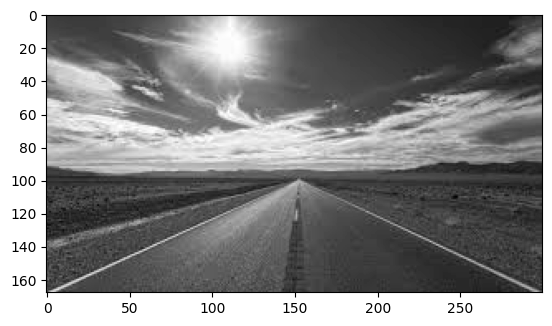

In [210]:
# Plotando a imagem
plt.imshow(img, cmap='gray')

A função filter implementa a aplicação de um filtro à imagem, realizando a convolução da imagem com o kernel.

In [ ]:
# Define uma função que aplica o filtro a uma imagem
def filter(img, kernel):
    
    # Cria uma imagem de saída com as dimensões da imagem original, mas com um pad nas bordas
    padded_img = np.pad(img, pad_width=1, mode='reflect')

    # Cria uma imagem de saída com as mesmas dimensões da imagem original
    output_img = np.zeros_like(img, dtype=np.float32)

    # Percorre cada pixel da imagem, assumindo um kernel 3x3
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            output_img[i, j] = np.sum(np.float16(padded_img[i-1:i+2, j-1:j+2])*kernel)

    # Retorna a imagem filtrada, convertendo para uint8
    output_img = cv2.convertScaleAbs(output_img)
    return output_img

In [114]:
# Define uma função para criar um kernel gaussiano
def gaussian_kernel(size, sigma):
    # Offset do centro do kernel
    k = size // 2 

    # Cria um grid 2D com valores de -k a k
    x, y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    # Cria o kernel gaussiano
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normaliza e retorna o kernel
    return kernel / np.sum(kernel) 

A primeira etapa de Canny consiste em aplicar o filtro gaussiano para diminuir os ruídos na imagem. Como pode ser visto abaixo, é gerado um kernel gaussiano 3x3 e em seguida a filtragem é realizada.

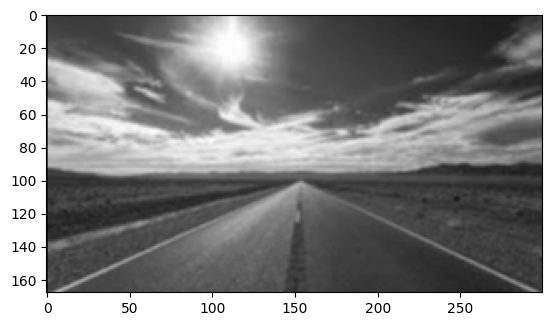

In [211]:
gaussian = gaussian_kernel(3, 1)

gaussian_img = filter(img, gaussian)

plt.imshow(gaussian_img, cmap='gray')

A segunda etapa consiste em aplicar o filtro de sobel, na direção x e y, obtendo a magnitude do gradiente.

In [212]:
# Define dois kernels de sobel, uma para detecção de bordas horizontais e outro para verticais
sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [213]:
# Aplica os kernels de sobel na imagem
sx = filter(img, sobelx)
sy = filter(img, sobely)

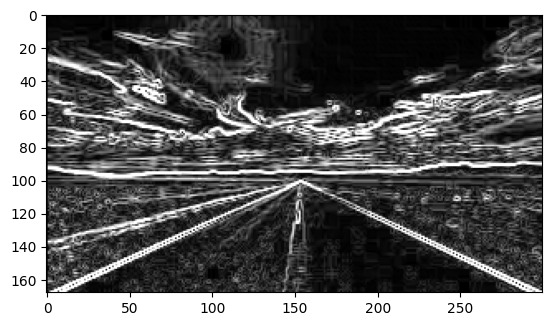

In [214]:
# Calculando a magnitude do gradiente
# Converte para float32 para evitar overflow
sobel = np.sqrt(np.square(sx.astype(np.float32)) + np.square(sy.astype(np.float32))) 
sobel = np.clip(sobel, 0, 255)  # Garante que os valores estejam no intervalo
sobel = sobel.astype(np.uint8)  # Converte para uint8

plt.imshow(sobel, cmap='gray')

Para o non maximum suppression é necessário também a direção do gradiente. É preciso olhar a direção do gradiente de um pixel para poder compará-lo com seus vizinhos que estão nessa mesma direção. Caso o pixel seja maior que esses vizinhos, eles devem ser zerados. Caso contrário, o próprio pixel será zerado.

In [215]:
def non_maximum_suppression(sobel, sx, sy):

    # Direção do gradiente em graus
    gradient_direction = np.arctan2(sy, sx) * (180 / np.pi)
    # Normaliza entre 0 e 180 graus
    gradient_direction = (gradient_direction + 180) % 180 

    # Inicializar a imagem de saída com zeros
    nms = sobel.copy()

    for i in range(1, sobel.shape[0]-1):  
        for j in range(1, sobel.shape[1]-1):
            # Determina as direções vizinhas a serem comparadas
            direction = gradient_direction[i, j]

            # Compara com os dois vizinhos na direção do gradiente
            # Horizontal
            if (0 <= direction < 22.5) or (157.5 <= direction <= 180):  
                if sobel[i, j] < sobel[i, j-1] or sobel[i, j] < sobel[i, j+1]:
                    nms[i, j] = 0
                else:
                    sobel[i, j-1] = 0
                    sobel[i, j+1] = 0

            # Diagonal principal
            elif 22.5 <= direction < 67.5: 
                if sobel[i, j] < sobel[i-1, j+1] or sobel[i, j] < sobel[i+1, j-1]:
                    nms[i, j] = 0
                else:
                    sobel[i-1, j+1] = 0
                    sobel[i+1, j-1] = 0

            # Vertical
            elif 67.5 <= direction < 112.5:  
                if sobel[i, j] < sobel[i-1, j] or sobel[i, j] < sobel[i+1, j]:
                    nms[i, j] = 0
                else:
                    sobel[i-1, j] = 0
                    sobel[i+1, j] = 0
      
            # Diagonal secundária
            elif 112.5 <= direction < 157.5:  
                if sobel[i, j] < sobel[i-1, j-1] or sobel[i, j] < sobel[i+1, j+1]:
                    nms[i, j] = 0
                else:
                    sobel[i-1, j-1] = 0
                    sobel[i+1, j+1] = 0

    return nms

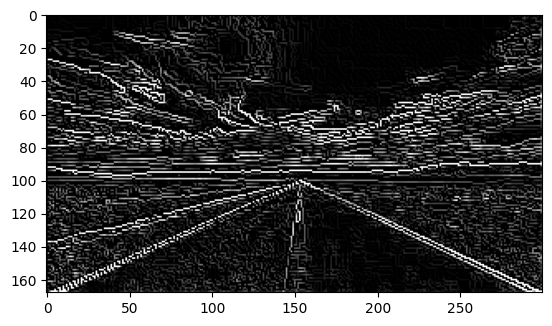

In [216]:
# Aplicando o non maximum suppression
supressed = non_maximum_suppression(sobel, sx, sy)
# Plotando o resultado
plt.imshow(supressed, cmap='gray')

Após o non maximum suppression é necessário realizar um duplo thresholding, visando classificar os pixels, eliminando aqueles considerados fracos.

In [217]:
def double_thresholding(img, low_threshold, high_threshold):

    # Cria a matriz de saída
    result = np.zeros_like(img, dtype=np.uint8)

    # Classifica os pixels em fortes, médios e fracos (não bordas)
    strong_pixels = img >= high_threshold
    median_pixels = (img >= low_threshold) & (img < high_threshold)
    weak_pixels = img < low_threshold

    result[strong_pixels] = 255
    result[median_pixels] = 128
    result[weak_pixels] = 0

    return result

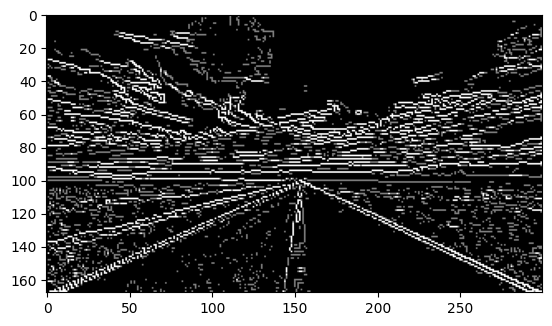

In [218]:
# Aplicando o duplo thresholding
threshholded = double_thresholding(supressed, 70, 140)
# Plotando o resultado
plt.imshow(threshholded, cmap='gray')

Por último, é preciso realizar a histerese, visando conectar pixels fortes que se ligam por meio de um pixel fraco. Assim, haverá menos buracos nas bordas.

In [219]:
def hysteresis(img):

    result = img.copy()

    for i in range(1, img.shape[0] - 1): 
        for j in range(1, img.shape[1] - 1):
            # Se o pixel for fraco, verificar vizinhança
            if img[i, j] == 128:
                neighborhood = img[i - 1:i + 2, j - 1:j + 2]
                if 255 in neighborhood:
                    # Promover a forte se houver pelo menos um vizinho forte
                    result[i, j] = 255
                # elif weak in neighborhood:
                #     # Manter fraco se houver outros vizinhos fracos
                #     result[i, j] = weak
                else:
                    # Eliminar se estiver isolado
                    result[i, j] = 0

    return result

Abaixo é mostrado o resultado obtido com a implementação do detector de bordas de Canny. (É necessário melhorar o algoritmo de histerese)

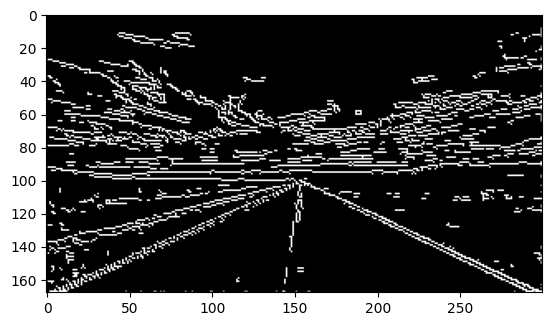

In [220]:
# Aplicando a histerese
hysteresis_img = hysteresis(threshholded)
# Plotando o resultado
plt.imshow(hysteresis_img, cmap='gray')

#### 2. Implemente uma função para detectar linhas retas em uma imagem de acordo com o algoritmo de Hough.

A transformada de Hough é uma técnica utilizada em processamento de imagens para detectar formas geométricas, sendo mais comumente aplicada na identificação de retas e círculos. Sua principal vantagem é a robustez na identificação de formas mesmo em cenários ruidosos ou com bordas incompletas.

Para detecção de retas, a transformada de Hough representa cada reta em uma forma polar: r=xcos⁡(θ)+ysin⁡(θ), onde r é a distância da origem à reta e θ é o ângulo de inclinação. Cada pixel na imagem que pertence a uma borda contribui para um espaço de parâmetros (r,θ), chamado de espaço de Hough. Os picos nesse espaço indicam as retas mais prováveis.

In [226]:
def hough_transform(img):

    # Valores de theta em radianos
    theta = np.deg2rad(np.arange(-90, 90, 1))

    # Máximo valor de r possível (diagonal da imagem)
    diag_len = int(np.ceil(np.sqrt(img.shape[0]**2 + img.shape[1]**2)))

    # Valores de r
    r = np.arange(-diag_len, diag_len, 1)

    # Inicializa o acumulador
    accumulator = np.zeros((len(r), len(theta)), dtype=np.int32)

    # usa os valores de r como índices na matriz
    r_index = diag_len

    # Encontra pixels não nulos na imagem (bordas)
    pixels = np.argwhere(img > 0)

    # Itera sobre os pixels de borda
    for y, x in pixels:
        for t_index, t in enumerate(theta):
            # Calcular r para o par (x, y) e theta
            r_val = int(x * np.cos(t) + y * np.sin(t))
            r_idx = r_val + r_index 
            accumulator[r_idx, t_index] += 1

    return accumulator, r, theta

In [227]:
acc, r, t = hough_transform(hysteresis_img)

Abaixo é plotado o espaço de Hough, onde é possível ver as senóides. Quanto mais interseções entre elas, maior a chance daquele ponto representar uma reta.

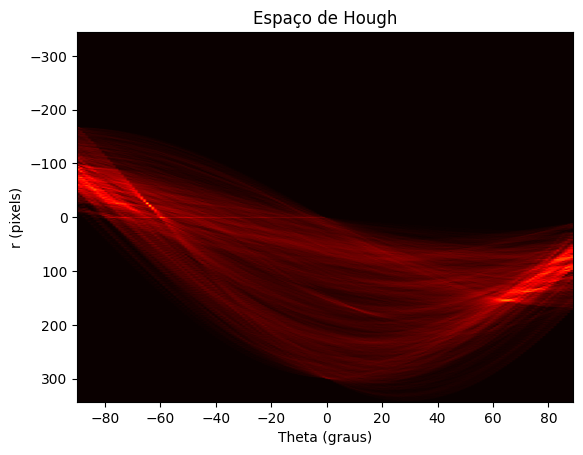

In [228]:
plt.imshow(acc, extent=[np.rad2deg(t[0]), np.rad2deg(t[-1]), r[-1], r[0]],cmap='hot', aspect='auto')
plt.title('Espaço de Hough')
plt.xlabel('Theta (graus)')
plt.ylabel('r (pixels)')
plt.show()

Para escolher os pontos que provavelmente correspondem a linhas é necessário delimitar um threshold. No caso abaixo, um valor 100. Para poder observá-las, faz-se necessário converter de coordenadas polares para cartesianas.

In [232]:
def draw_hough_lines(image, accumulator, r_vals, theta_vals, threshold):
    # Cria uma cópia da imagem original para desenhar
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Encontra os picos no acumulador
    peaks = np.argwhere(accumulator > threshold)

    # Desenha as retas correspondentes
    for r_idx, t_idx in peaks:
        r = r_vals[r_idx]
        theta = theta_vals[t_idx]
        
        # Converte de polar para cartesiano
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * r
        y0 = b * r

        # Ponto 1 da linha
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        # Ponto 2 da linha
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        
        # Desenha a linha
        cv2.line(output, (x1, y1), (x2, y2), (0, 0, 255), 1)

    return output

Abaixo é possível ver o resultado da implementação da transformada de Hough.

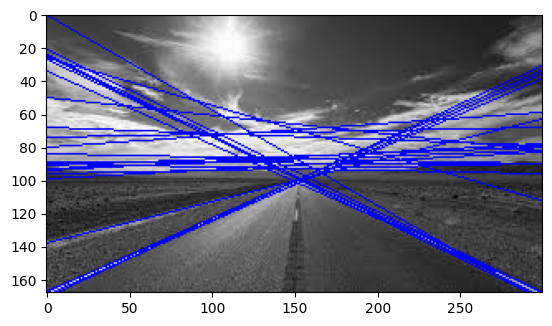

In [235]:
# Desenhando as linhas obtidas pela transformada de Hough
hg = draw_hough_lines(img, acc, r, t, 100)
# Plotando o resultado
plt.imshow(hg)